In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

In [4]:
res = []
with open('test2.log', 'r') as lines:
    numRows = 0
    tmp = []
    for line in lines:
        if line.strip() != '---':
            if len((line.strip().split(':'))[1].strip()):
                tmp.append(to_num((line.strip().split(':'))[1].strip()))
        else:
            res.append(tmp)
            tmp = []
            
            
cols = ['seq', 'secs', 'nsecs', 'frame_id', 'utm_east', 'utm_north',
       'utm_up', 'roll', 'pitch', 'yaw', 'velo_north',
       'velo_east', 'velo_down', 'velo_robot_x',
       'velo_robot_y', 'velo_robot_z', 'acc_robot_x',
       'acc_robot_y', 'acc_robot_z', 'omega_yaw', 'omega_pitch',
       'omega_roll', 'nav_mode', 'pos_mode', 'vel_mode']

df = pd.DataFrame(res, columns=cols)
df = df.drop(columns = ['seq', 'frame_id'])

In [5]:
df = pd.DataFrame(res, columns=cols)
df = df.drop(columns = ['seq', 'frame_id'])

In [6]:
# Moving Average
def MA(seq, w):
    """
    Moving average
    seq: sequence; w: window size
    """
    out0 = np.convolve(seq,np.ones(w,dtype=int),'valid')/w
    r = np.arange(1,w-1,2)
    start = np.cumsum(seq[:w-1])[::2]/r
    stop = (np.cumsum(seq[:-w:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [7]:
# utm_east, utm_north, velo_robot_x, yaw -- highly confident

In [8]:
x = df.utm_east
y = df.utm_north
z = df.utm_up
roll = df.roll
pitch = df.pitch
yaw = df.yaw

### Erase bias

In [9]:
pitch2 = pitch.copy()
pitch2[pitch>np.pi] = 2*np.pi - pitch[pitch>np.pi]
pitch2[pitch<=np.pi] = - pitch[pitch<=np.pi]
shift = 0.04 # approximate shift
pitch2 = pitch2 - shift

# FFT

In [10]:
xx = np.linspace(0, 10,200)
y1 = np.sin(1/2*np.pi*xx)
y2 = np.sin(np.pi*xx+2)
y3 = np.sin(2*np.pi*xx)*3

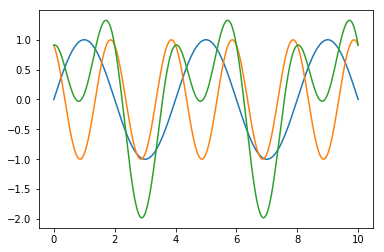

In [11]:
plt.plot(xx,y1,xx,y2,xx,y1+y2)

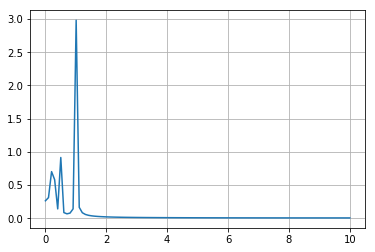

In [12]:
from scipy.fftpack import fft
N = 200
T = 0.05
yf = fft(y1+y2+y3)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

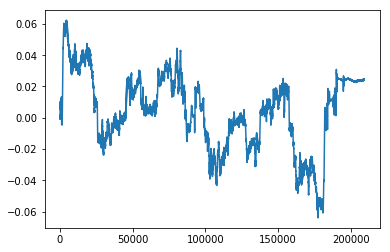

In [13]:
plt.plot(pitch2)

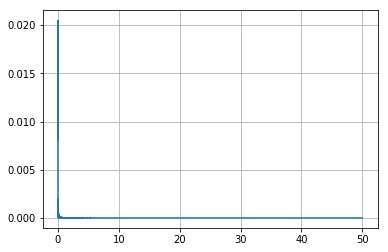

In [14]:
import numpy.fft as fft
N = len(pitch)
T = 0.01
xf = np.linspace(0.0, 1.0/(2*T), N//2)
spectrum = fft.fft(pitch2)

freq = fft.fftfreq(len(spectrum))
plt.plot(xf, abs(spectrum[0:N//2])/N*2)
plt.grid()

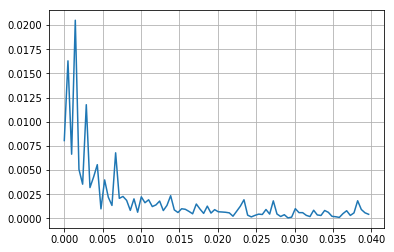

In [15]:
yyy = abs(spectrum[0:N//2])/N*2
idx = np.where(xf<0.04)[0]
plt.plot(xf[idx], yyy[idx])
plt.grid()

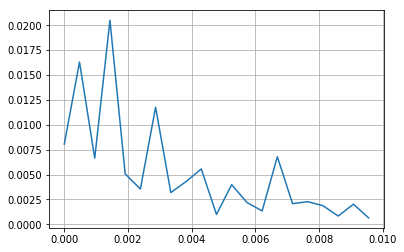

In [16]:
yyy = abs(spectrum[0:N//2])/N*2
idx = np.where(xf<0.01)[0]
plt.plot(xf[idx], yyy[idx])
plt.grid()
# sorted(yyy, key = lambda x: x, reverse=True)

# Pitch decomposition

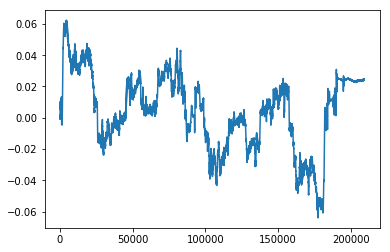

In [17]:
plt.plot(pitch2)

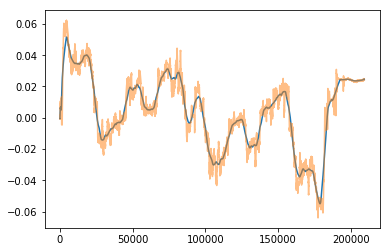

In [18]:
ws = 5001 # window size
pitch_ma = MA(pitch2, ws)
plt.plot(pitch_ma)
plt.plot(pitch2, alpha=0.5)

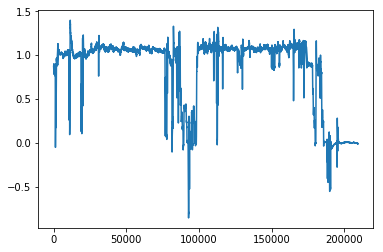

In [19]:
plt.plot(df.velo_robot_x)

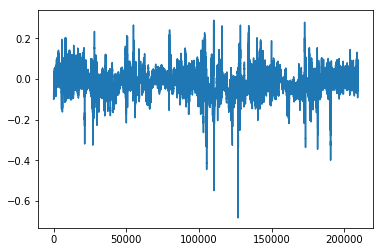

In [20]:
plt.plot(df.velo_robot_z)

### remove info from asymmetric track

In [21]:
n_s = 0 # starting
n_h = np.array(df.utm_east).argmin() # half
n_e = np.where(df.utm_east>df.utm_east[0])[0][0] - 1 # ending

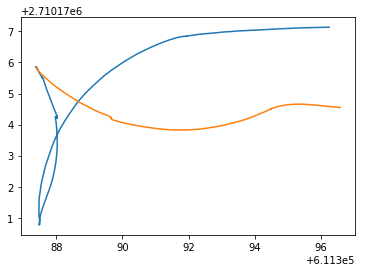

In [22]:
# remove the asymmetric track part
plt.plot(df.utm_east[n_h-7000:n_h], df.utm_north[n_h-7000:n_h])
plt.plot(df.utm_east[n_h:n_h+3900], df.utm_north[n_h:n_h+3900]);

In [23]:
# Moving Average
def MA(seq, w):
    """
    Moving average
    seq: sequence; w: window size
    """
    out0 = np.convolve(seq,np.ones(w,dtype=int),'valid')/w
    r = np.arange(1,w-1,2)
    start = np.cumsum(seq[:w-1])[::2]/r
    stop = (np.cumsum(seq[:-w:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [24]:
n1_s = n_s
n1_e = n_h-7000
n2_s = n_h+3900
n2_e = n_e
n1 = list(range(n1_s, n1_e)) # idx of first half
n2 = list(range(n2_s, n2_e)) # idx of second half

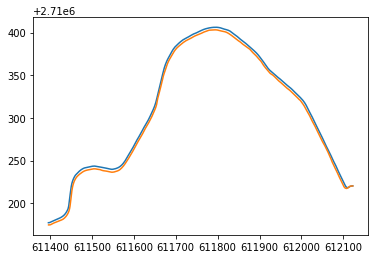

In [25]:
plt.plot(x[n1], y[n1])
plt.plot(x[n2], y[n2])

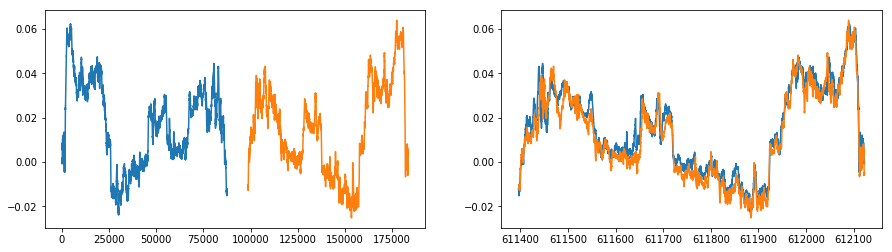

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(pitch2[n1])
plt.plot(-pitch2[n2])
plt.subplot(122)
plt.plot(x[n1], pitch2[n1])
plt.plot(x[n2], -pitch2[n2])

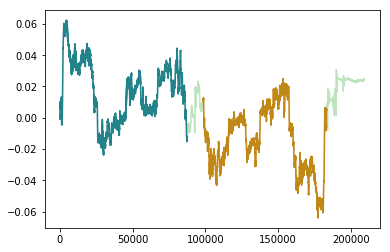

In [27]:
plt.plot(pitch2[n1])
plt.plot(pitch2[n2])
plt.plot(pitch2, alpha=0.3)

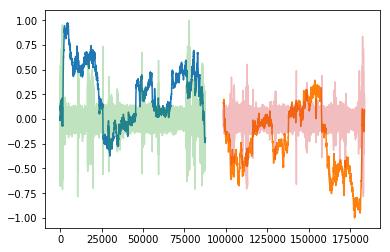

In [28]:
pitch2_tmp = pitch2/abs(pitch2).max()
acc_x_tmp = df.acc_robot_x/abs(df.acc_robot_x).max()
velo_x_tmp = df.velo_robot_x/abs(df.velo_robot_x).max()
plt.plot(pitch2_tmp[n1])
plt.plot(pitch2_tmp[n2])
plt.plot(acc_x_tmp[n1], alpha=0.3)
plt.plot(acc_x_tmp[n2], alpha=0.3)

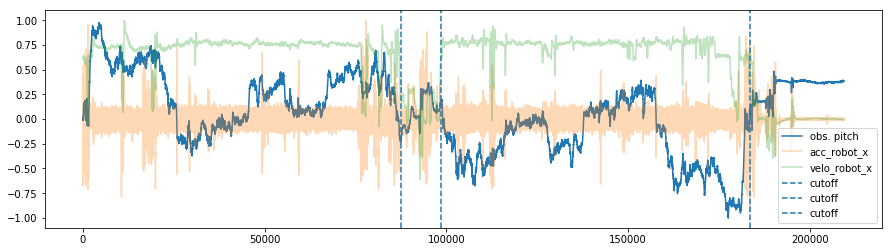

In [29]:
plt.figure(figsize=(15,4))
plt.plot(pitch2_tmp, label='obs. pitch')
plt.plot(acc_x_tmp, alpha=0.3, label='acc_robot_x')
plt.plot(velo_x_tmp, alpha=0.3, label='velo_robot_x')
plt.axvline(n1_e, ls='--', label='cutoff')
plt.axvline(n2_s, ls='--', label='cutoff')
plt.axvline(n_e, ls='--', label='cutoff')
plt.legend()

In [30]:
tmp1 = MA(pitch2_tmp[n1],101)
tmp2 = pitch2_tmp[n1]-tmp1
tmp2 = tmp2/np.abs(tmp2).max()

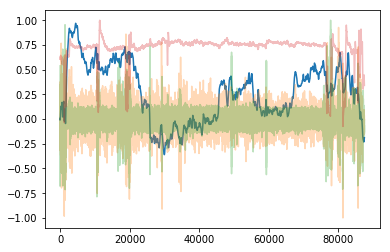

In [31]:
plt.plot(MA(pitch2_tmp[n1],101))
plt.plot(tmp2, alpha=0.3)
plt.plot(acc_x_tmp[n1], alpha=0.3)
plt.plot(velo_x_tmp[n1], alpha=0.3)

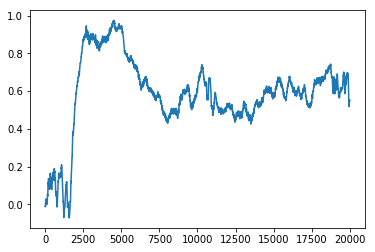

In [32]:
plt.plot(pitch2_tmp[:20000])

In [33]:
tmp1 = MA(pitch2_tmp[n1],101)
tmp2 = pitch2_tmp[n1]-tmp1
tmp2 = tmp2/np.abs(tmp2).max()

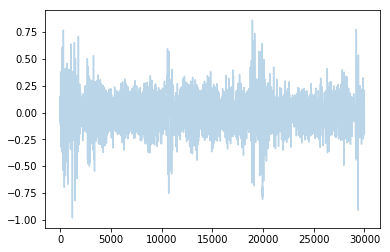

In [34]:
plt.plot(tmp2[:30000], alpha=0.3)

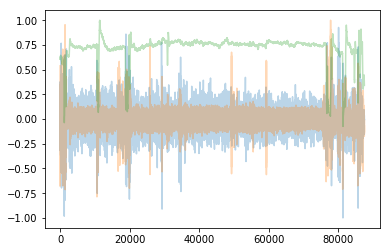

In [35]:
plt.plot(tmp2, alpha=0.3)
plt.plot(acc_x_tmp[n1], alpha=0.3)
plt.plot(velo_x_tmp[n1], alpha=0.3)

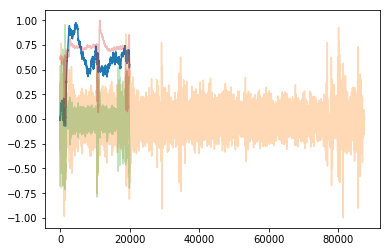

In [36]:
plt.plot(MA(pitch2_tmp[:20000],1))
plt.plot(tmp2, alpha=0.3)
plt.plot(acc_x_tmp[:20000], alpha=0.3)
plt.plot(velo_x_tmp[:20000], alpha=0.3)

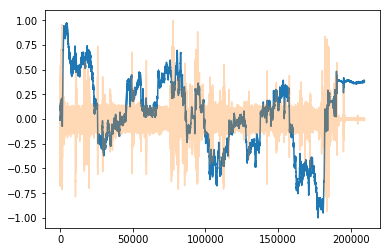

In [37]:
plt.plot(pitch2/abs(pitch2).max())
plt.plot(df.acc_robot_x/abs(df.acc_robot_x).max(), alpha=0.3)

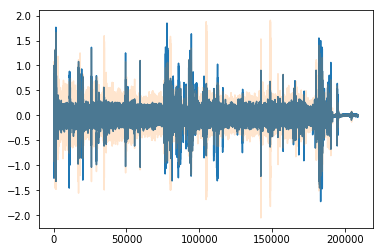

In [38]:
plt.plot(df.acc_robot_x)
plt.plot(-df.acc_robot_z, alpha=0.2)

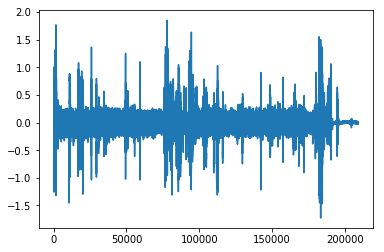

In [39]:
plt.plot(df.acc_robot_x)

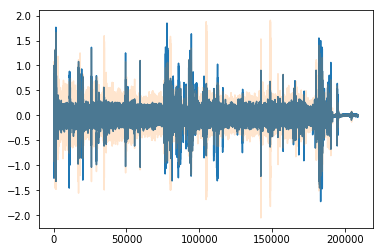

In [40]:
plt.plot(df.acc_robot_x)
plt.plot(-df.acc_robot_z, alpha=0.2)

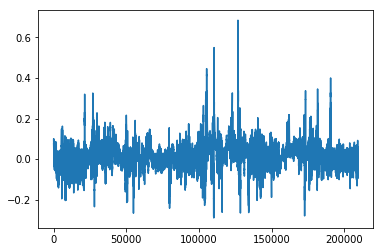

In [41]:
plt.plot(df.velo_down)

In [42]:
(pitch2[n1].max() + pitch2[n2].min())/2

-0.0008001597232067774

In [43]:
(pitch2[n1].min() + pitch2[n2].max())/2

0.0006653126695859504

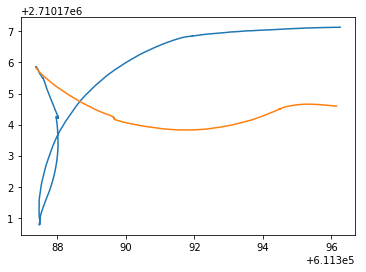

In [44]:
plt.plot(df.utm_east[n_h-7000:n_h], df.utm_north[n_h-7000:n_h])
plt.plot(df.utm_east[n_h:n_h+3850], df.utm_north[n_h:n_h+3850])

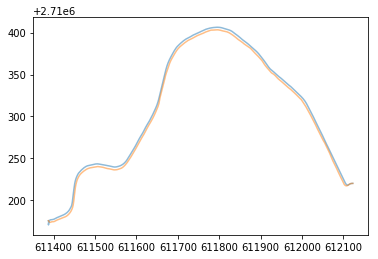

In [45]:
plt.plot(df.utm_east[:n_h], df.utm_north[:n_h], df.utm_east[n_h:n_e], df.utm_north[n_h:n_e], alpha = 0.5)

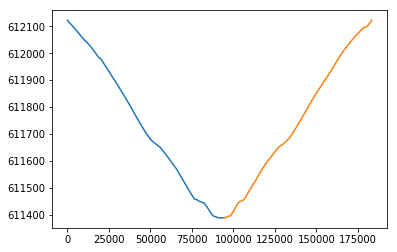

In [46]:
plt.plot(df.utm_east[:n_h])
plt.plot(df.utm_east[n_h:n_e])

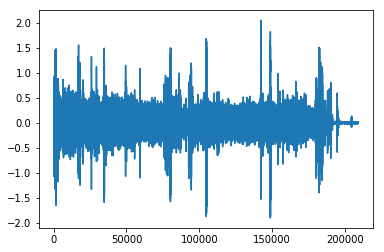

In [47]:
plt.plot(df.acc_robot_z)

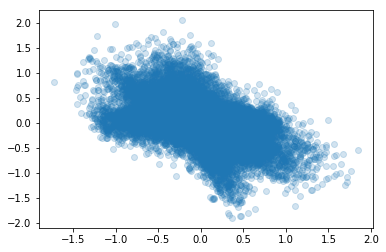

In [48]:
plt.plot(df.acc_robot_x, df.acc_robot_z, 'o', alpha=0.2)

In [49]:
np.corrcoef(df.acc_robot_z, df.acc_robot_x)

array([[ 1.        , -0.42615616],
       [-0.42615616,  1.        ]])

In [50]:
np.corrcoef(df.acc_robot_z, df.acc_robot_y)

array([[1.        , 0.06150235],
       [0.06150235, 1.        ]])

In [51]:
np.corrcoef(df.acc_robot_y, df.acc_robot_x)

array([[ 1.        , -0.09657943],
       [-0.09657943,  1.        ]])

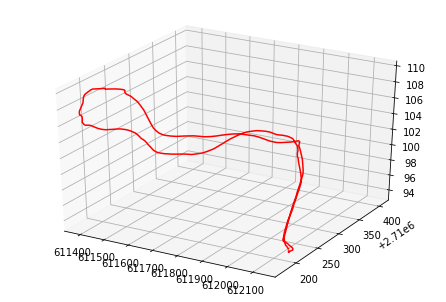

In [52]:
fig=plt.figure()
ax = Axes3D(fig)
# ax.set_aspect('equal')
ax.plot(x, y, MA(z,10001), c='red')

In [53]:
x = np.array(df.utm_east)
y = np.array(df.utm_north)
z = np.array(df.utm_up)
n = len(x) # num of timestamps /0.01s

# n_h = int(n/2) # n half by time
n_h = x.argmin() # n half by space

In [54]:
(np.mean(pitch2[n1])+np.mean(pitch2[n2]))/2

0.0011809684873463266

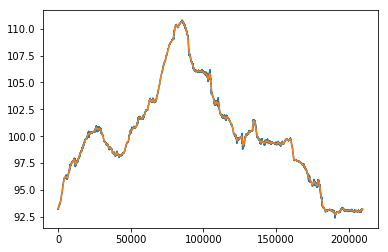

In [55]:
plt.plot(z)
plt.plot(MA(z,1001))

In [56]:
pitch_s=(np.sin(2*np.pi-pitch))

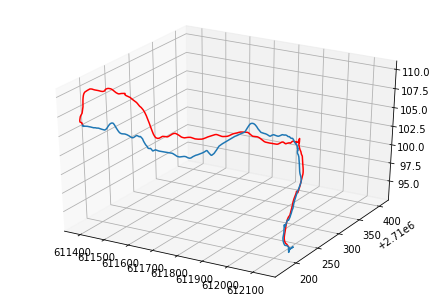

In [57]:
fig=plt.figure()
ax = Axes3D(fig)
ax.plot(x[:n_h], y[:n_h], MA(z,1001)[:n_h], c='red')
ax.plot(x[n_h:], y[n_h:], MA(z,1001)[n_h:])

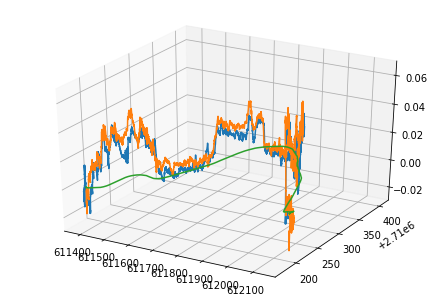

In [58]:
fig=plt.figure()
ax = Axes3D(fig)
ax.plot(x[:n_h], y[:n_h], pitch_s[:n_h]-np.mean(pitch_s))
ax.plot(x[n_h:], y[n_h:], -pitch_s[n_h:]+np.mean(pitch_s))
ax.plot(x[n_h:], y[n_h:], 0);

In [59]:
v_x = df.velo_robot_x
v_x_ma = MA(v_x, 1001)
pitch_ma = MA(pitch_s, 1001)
h0 = z[0]
h = v_x_ma *0.01 * ((pitch_ma-np.mean(pitch_ma)))
H = h.cumsum() + h0 # integrated using v_x and pitch
z_ma = MA(z, 10001)

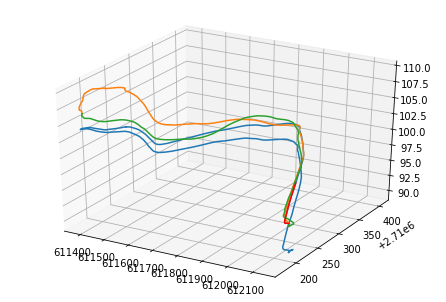

In [60]:
fig=plt.figure()
ax = Axes3D(fig)
ax.plot(x, y, H)
ax.plot(x[:10000], y[:10000], H[:10000], c='red', zorder=10)
ax.plot(x[:n_h], y[:n_h], z_ma[:n_h])
ax.plot(x[n_h:], y[n_h:], z_ma[n_h:]);

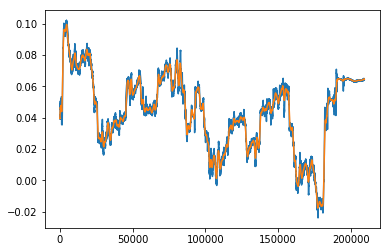

In [61]:
plt.plot(pitch_s)
plt.plot(pitch_ma);

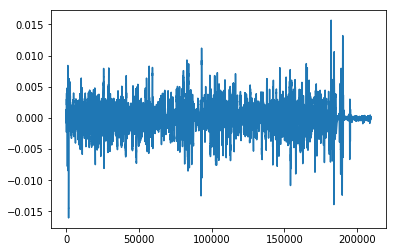

In [62]:
plt.plot(pitch_s - pitch_ma)

In [63]:
s_d = np.sqrt(df.utm_east.diff()**2 + df.utm_north.diff()**2)
z_d = df.utm_up.diff()

/home/stve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arctan
  """Entry point for launching an IPython kernel.


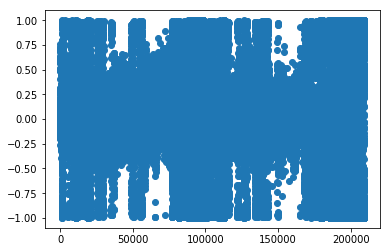

In [64]:
plt.plot(np.sin(np.arctan(z_d/s_d)), 'o')

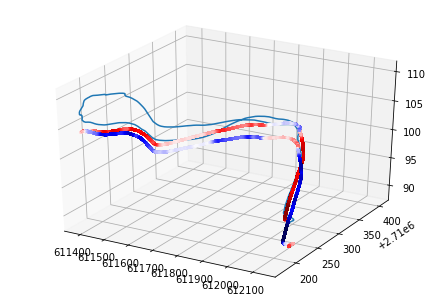

In [65]:
fig=plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, H, c=pitch_ma-np.mean(pitch_ma), cmap = "seismic", s=3);
ax.plot(x, y, z_ma);

In [66]:
shift

0.04

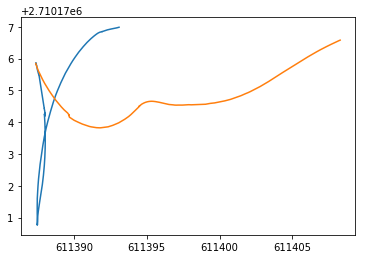

In [67]:
plt.plot(df.utm_east[n_h-6000:n_h], df.utm_north[n_h-6000:n_h])
plt.plot(df.utm_east[n_h:n_h+5000], df.utm_north[n_h:n_h+5000])

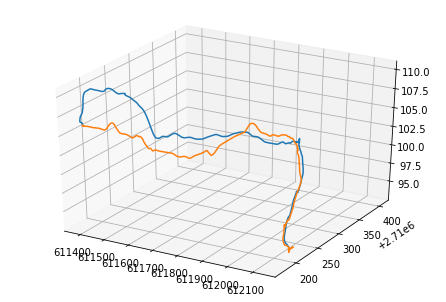

In [68]:
fig=plt.figure()
ax = Axes3D(fig)
ax.plot(x[:n_h], y[:n_h], MA(df.utm_up, 1001)[:n_h])
ax.plot(x[n_h:], y[n_h:], MA(df.utm_up, 1001)[n_h:])

# Week 2

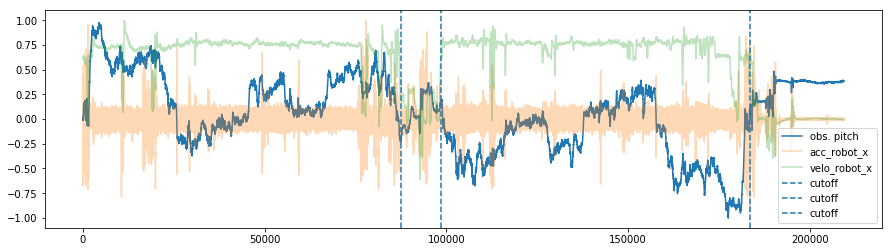

In [69]:
plt.figure(figsize=(15,4))
plt.plot(pitch2_tmp, label='obs. pitch')
plt.plot(acc_x_tmp, alpha=0.3, label='acc_robot_x')
plt.plot(velo_x_tmp, alpha=0.3, label='velo_robot_x')
plt.axvline(n1_e, ls='--', label='cutoff')
plt.axvline(n2_s, ls='--', label='cutoff')
plt.axvline(n_e, ls='--', label='cutoff')
plt.legend()

In [70]:
from scipy.interpolate import interp1d

In [71]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

(array([   302.,    709.,   1559.,  25393.,   7286.,   6348.,   3198.,
         17136., 143890.,   3496.]),
 array([-0.85451734, -0.62935267, -0.404188  , -0.17902333,  0.04614134,
         0.27130601,  0.49647068,  0.72163535,  0.94680002,  1.17196469,
         1.39712936]),
 <a list of 10 Patch objects>)

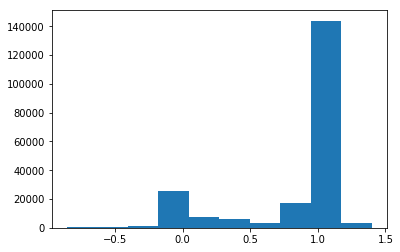

In [72]:
v = df.velo_robot_x
acc = df.acc_robot_x
plt.hist(v)

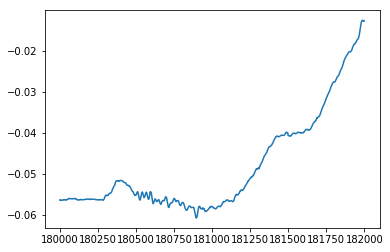

In [73]:
plt.plot(pitch2[180000:182000])

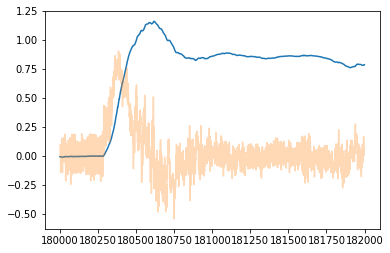

In [74]:
plt.plot(v[180000:182000])
plt.plot(df.acc_robot_x[180000:182000],alpha=0.3)

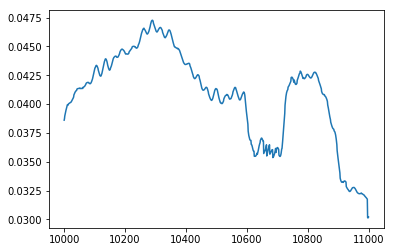

In [75]:
plt.plot(pitch2[10000:11000])

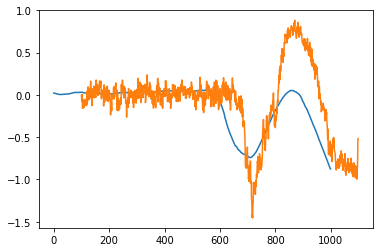

In [76]:
plt.plot(range(1000),v[10000:11000]-1)
plt.plot(range(100,1000+100),df.acc_robot_x[10000:11000])

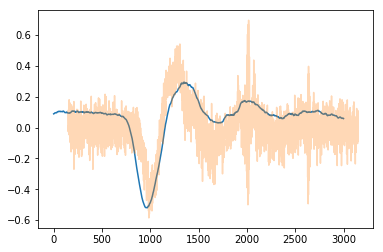

In [77]:
plt.plot(range(3000),v[164000:167000]-1)
plt.plot(range(150,3000+150),df.acc_robot_x[164000:167000],alpha=0.3)

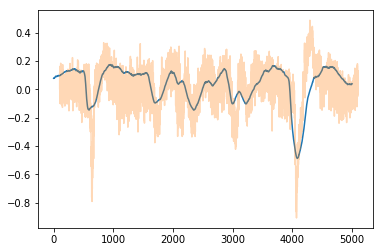

In [78]:
plt.plot(range(5000),v[168000:173000]-1)
plt.plot(range(100,5000+100),MA(df.acc_robot_x[168000:173000],1), alpha = 0.3)

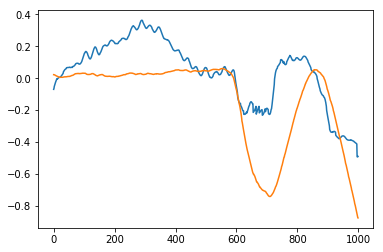

In [79]:
plt.plot(range(1000),pitch2[10000:11000]*50-2)
plt.plot(range(1000),v[10000:11000]-1)

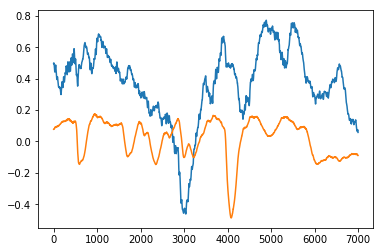

In [80]:
plt.plot(range(7000),pitch2[168000:175000]*50+2)
plt.plot(range(7000),v[168000:175000]-1)

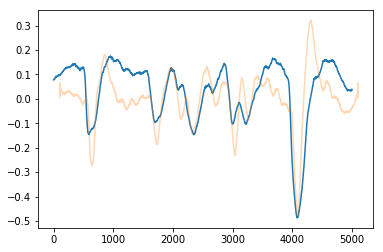

In [81]:
plt.plot(range(5000),v[168000:173000]-1)
plt.plot(range(100,5000+100),MA(df.acc_robot_x[168000:173000],101), alpha = 0.3)

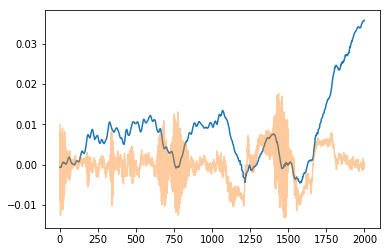

In [82]:
plt.plot(pitch2[:2000])
plt.plot(df.acc_robot_x[:2000]/100, alpha=0.4)

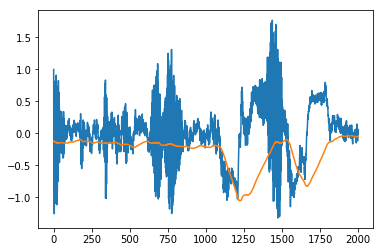

In [83]:
plt.plot(df.acc_robot_x[:2000])
plt.plot(v[:2000]-1)

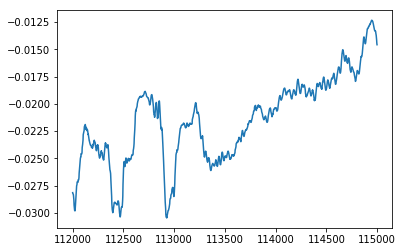

In [84]:
plt.plot(pitch2[112000:115000])

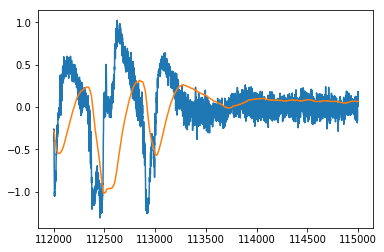

In [85]:
plt.plot(df.acc_robot_x[112000:115000])
plt.plot(v[112000:115000]-1)

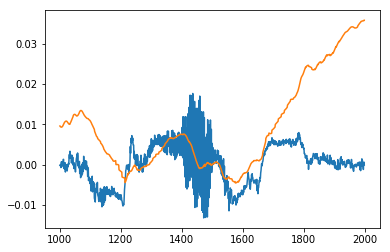

In [86]:
ind = list(range(1000,2000))
plt.plot(df.acc_robot_x[ind]/100)
plt.plot(pitch2[ind])

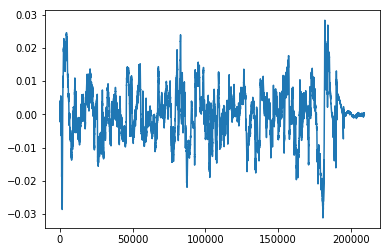

In [87]:
plt.plot(pitch2-MA(pitch2, 10001))

In [88]:
from scipy.ndimage.filters import gaussian_filter1d

In [89]:
gg = gaussian_filter1d(acc,100)
gg = gg/np.abs(gg).max()
pitch_norm = pitch2/np.abs(pitch2).max()

In [90]:
gg = gaussian_filter1d(acc,10)
gg = gg/np.abs(gg).max()
pitch_norm = pitch2/np.abs(pitch2).max()

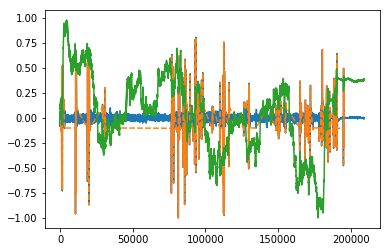

In [91]:
plt.plot(gg)
plt.plot(np.where(np.abs(gg)>0.1)[0], gg[np.abs(gg)>0.1], '--')
plt.plot(pitch_norm)

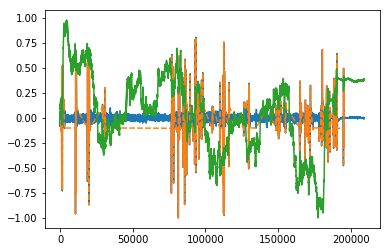

In [92]:
plt.plot(gg)
plt.plot(np.where(np.abs(gg)>0.1)[0], gg[np.abs(gg)>0.1], '--')
plt.plot(pitch_norm)

In [93]:
# thresholding function
def TH(x, th):
    """
    thresholding function
    th is the relative threshold, ratio to the largest abs value
    """
    
    x_n = x/np.abs(x).max()
    res = x_n.copy()
    res[np.abs(res)<th] = 0
    return res

In [94]:
def shrink(x, scale = 0.01):
    """
    """
    
    res = x/(x+1)
#     res = np.sign(res)*np.sqrt(np.abs(x))
    res = np.sign(res)*np.abs(x)/(2*np.abs(x)+1)
    res *= scale
    
    return res

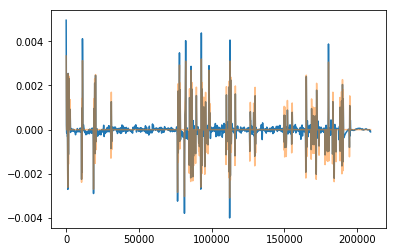

In [95]:
acc0 = gaussian_filter1d(acc, 100, mode='nearest')
plt.plot(acc0/100)
bias = TH(acc0, 0.1)
bias = shrink(bias)
plt.plot(bias, alpha=0.5)

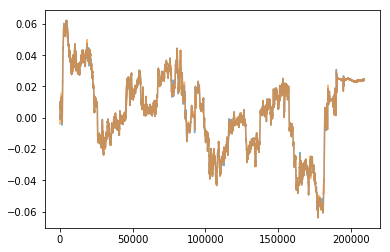

In [96]:
pitch3 = pitch2 - bias
plt.plot(pitch2, alpha=0.6)
plt.plot(pitch3, alpha=0.6)

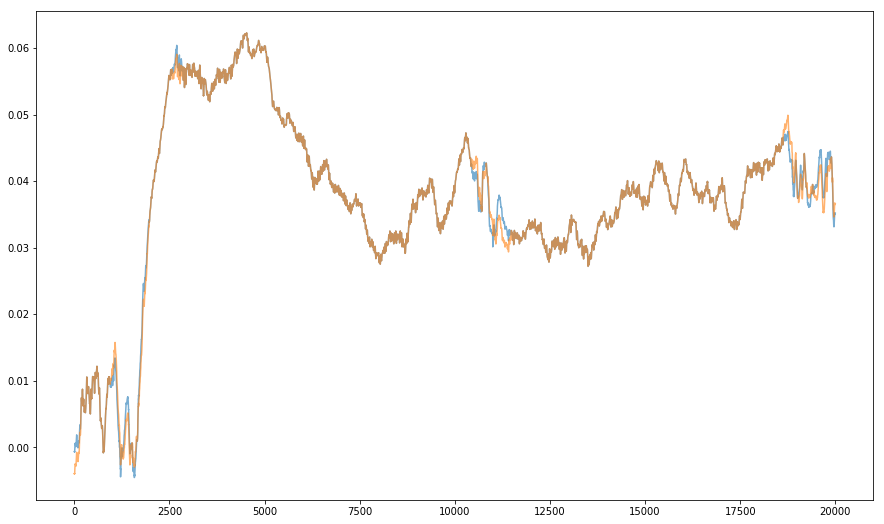

In [97]:
plt.figure(figsize=(15,9))
plt.plot(pitch2[:20000], alpha=0.6)
plt.plot(pitch3[:20000], alpha=0.6)

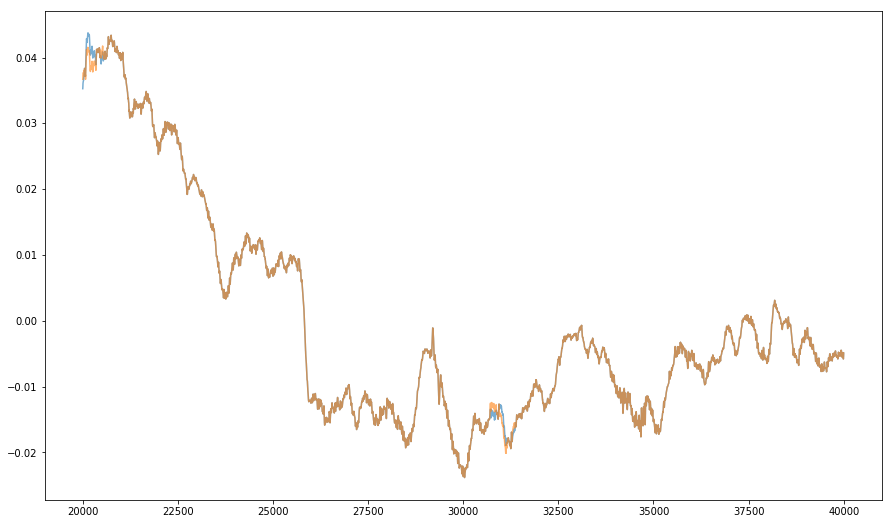

In [98]:
plt.figure(figsize=(15,9))
plt.plot(pitch2[20000:40000], alpha=0.6)
plt.plot(pitch3[20000:40000], alpha=0.6)

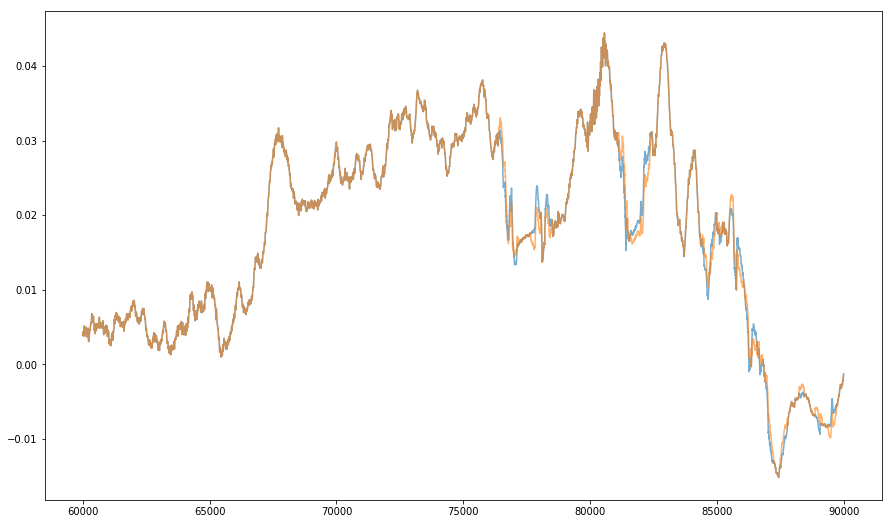

In [99]:
plt.figure(figsize=(15,9))
plt.plot(pitch2[60000:90000], alpha=0.6)
plt.plot(pitch3[60000:90000], alpha=0.6)

In [100]:
pitch_smooth = gaussian_filter1d(pitch3, 1000, mode ='nearest')
pitch_noise = pitch3 - pitch_smooth

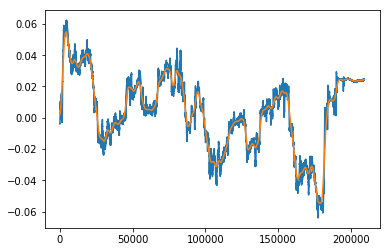

In [101]:
plt.plot(pitch3)
plt.plot(pitch_smooth)

In [102]:
# MA, gaussian, kalman filters

In [103]:
g_n = gaussian_filter1d(pitch2, 3000,mode='nearest')

In [104]:
gn1 = gaussian_filter1d(pitch2[n1], 3000,mode='nearest')
gn2 = gaussian_filter1d(pitch2[n2], 3000,mode='nearest')

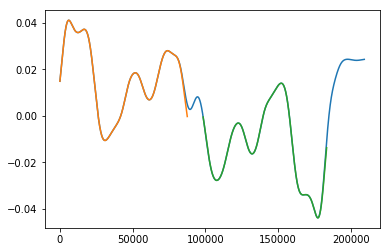

In [105]:
plt.plot(g_n)
plt.plot(n1,gn1)
plt.plot(n2,gn2)

# Model

I model mean of $pitch$ as the function of $x$ (utm_north) and $y$ (utm_east) plus a bias term $g(acc)$ which is some function of $acc$.

For the random noise, I assume we have a gaussian noise which has a greater deviation at the bumpers.

$$
pitch_t = f(x_t,y_t) + g(acc_t) + \sigma_0 + I_{bumper}*\sigma_{bumper}
$$

or alternatively

$$
pitch_t = f(x_t,y_t) + g(acc_t) + \sigma(acc_t)
$$


The bumpers have 2 effects:

1. bumpers will increase the amplitude of the observation of pitch (greater noise)

2. when the bumpers are significant enough, the motion of the sensor would lead to bias of pitch observation.

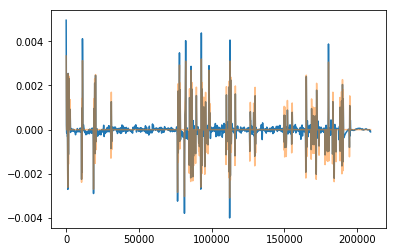

In [106]:
# filter noise in acc
acc0 = gaussian_filter1d(acc, 100, mode='nearest')
plt.plot(acc0/100)
# use thresholding to choose the bumper places
bias = TH(acc0, 0.1)
# bias = TH(acc, 0.2)
# shrink the effects of bumper
bias = shrink(bias)
plt.plot(bias, alpha=0.5)

In [107]:
# reduce bias
pitch3 = pitch2 - bias
# filter out random noise
pitch_smooth = gaussian_filter1d(pitch3, 1000, mode ='nearest')
pitch_noise = pitch3 - pitch_smooth

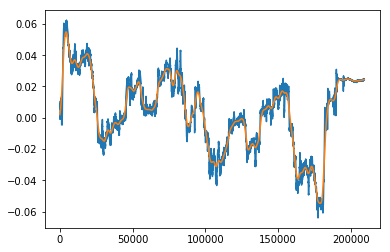

In [108]:
plt.plot(pitch2)
plt.plot(pitch_smooth)

# Cubic Interpolate

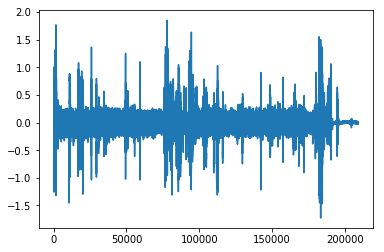

In [109]:
plt.plot(acc)

In [110]:
from scipy.interpolate import interp1d

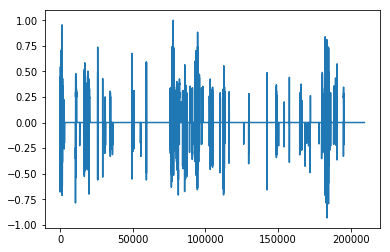

In [111]:
plt.plot(TH(acc, 0.2))

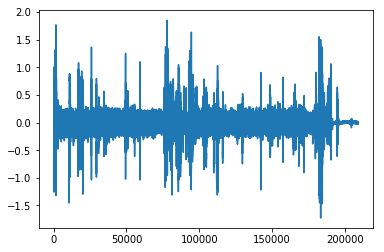

In [112]:
plt.plot(acc)

plt.plot(MA(pitch2, 5001))
plt.plot(pitch2, alpha=0.4)

In [113]:
def fit_curve(idx, mode='cubic'):
    """
    
    """
    
    idx = np.array(idx)
    if mode == 'cubic':
        X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
    elif mode == "linear":
        X = np.c_[np.ones(len(idx)), idx]
    elif mode == 'quadratic':
        X = np.c_[np.ones(len(idx)), idx, idx**2]
        
    y = pitch2[idx]
    para = np.linalg.pinv(X).dot(y)
    fit = X.dot(para)
#     return para
    return fit

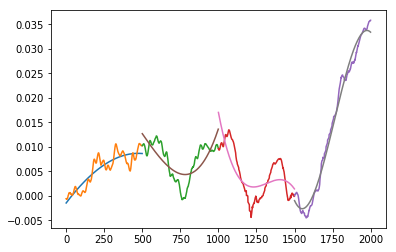

In [114]:
plt.plot(fit_curve(range(500)))
plt.plot(pitch2[list(range(500))])
plt.plot(pitch2[list(range(500,1000))])
plt.plot(pitch2[list(range(1000,1500))])
plt.plot(pitch2[list(range(1500,2000))])
plt.plot(range(500,1000), fit_curve(range(500,1000)))
plt.plot(range(1000,1500), fit_curve(range(1000,1500)))
plt.plot(range(1500,2000), fit_curve(range(1500,2000)))

In [115]:
n_w * 500

NameError: name 'n_w' is not defined

In [ ]:
res = []
window = 500
n = len(pitch2)
n_w = n//window + 1
plt.figure(figsize=(15,5))
for i in range(n_w):
    if (i+1)*window <= n:
        idx = list(range(i*window, (i+1)*window))
    else:
        idx = list(range(i*window, n))
    fit = fit_curve(idx)
    res.append(np.linalg.norm(fit-pitch2[idx]))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(res, 'o')
plt.axhline(np.percentile(np.array(res), 90))

In [ ]:
idx = list(range(500))
idx.extend(list(range(1000,1500)))
para = fit_curve(idx)
idx = np.arange(1500)
X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
Y = X.dot(para)
plt.plot(idx, Y)
plt.plot(pitch2[:1500])

In [ ]:
idx = list(range(500,1000))
idx.extend(list(range(1500,2000)))
para = fit_curve(idx)
idx = np.arange(500,2000)
X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
Y = X.dot(para)
plt.plot(idx, Y)
plt.plot(pitch2[500:2000])

In [ ]:
idx = list(range(1000,1500))
idx.extend(list(range(2000,2500)))
para = fit_curve(idx)
idx = np.arange(1000,2500)
X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
Y = X.dot(para)
plt.plot(idx, Y)
plt.plot(pitch2[1000:2500])

In [ ]:
idx = list(range(1500,2000))
idx.extend(list(range(2500,3000)))
para = fit_curve(idx)
idx = np.arange(1500,3000)
X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
Y = X.dot(para)
plt.plot(idx, Y)
plt.plot(pitch2[1500:3000])

In [ ]:
idx = list(range(4500,5000))
idx.extend(list(range(5500,6000)))
para = fit_curve(idx)
idx = np.arange(4500,6000)
X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
Y = X.dot(para)
plt.plot(idx, Y)
plt.plot(pitch2[4500:6000])

In [ ]:
def fit_curve2(idx, mode='cubic'):
    """
    
    """
    
    idx = np.array(idx)
    if mode == 'cubic':
        X = np.c_[np.ones(len(idx)), idx, idx**2, idx**3]
    elif mode == "linear":
        X = np.c_[np.ones(len(idx)), idx]
    elif mode == 'quadratic':
        X = np.c_[np.ones(len(idx)), idx, idx**2]
        
    y = pitch2[idx]
    para = np.linalg.pinv(X).dot(y)
    fit = X.dot(para)
    return para
#     return fit

In [ ]:
res2 = []
window = 500
n = len(pitch2)
n_w = n//window + 1
# plt.figure(figsize=(15,5))
for i in range(n_w-2):
    if (i+3)*window <= n:
        idx = list(range(i*window, (i+1)*window))
        idx.extend(list(range((i+2)*window, (i+3)*window)))
    else:
        idx = list(range(i*window, (i+1)*window))
        idx.extend(list(range((i+2)*window, n)))
#     res2.append((idx))
#     print(len(idx))
    idx_fit = np.array(list(range((i+1)*window, (i+2)*window)))
    X_fit = np.c_[np.ones(len(idx_fit)), idx_fit, idx_fit**2, idx_fit**3]
    para = fit_curve2(idx)
    res2.append(np.linalg.norm(X_fit.dot(para)-pitch2[idx_fit]))
#     res.append(np.linalg.norm(fit-pitch2[idx]))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(res, 'o', label = 'cubic fit')
plt.axhline(np.percentile(np.array(res), 90))
plt.plot(res2, 'o', label = 'neighbors cubic fit')
plt.axhline(np.percentile(np.array(res2), 90))
plt.legend();

In [2]:
res

NameError: name 'res' is not defined

# B-spline

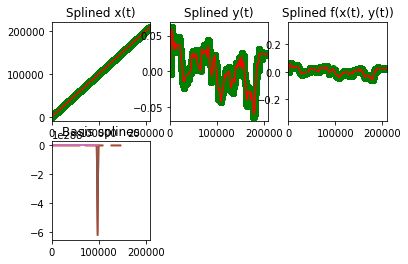

In [483]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si

points = [[0, 0], [0, 2], [2, 3], [4, 0], [6, 3], [8, 2], [8, 0]];
points = np.array(points)
x = np.arange(len(pitch2))
y = pitch2

t = range(len(x))
ipl_t = np.linspace(0.0, len(x) - 1, 100)

x_tup = si.splrep(t, x, k=3)
y_tup = si.splrep(t, y, k=3)

x_list = list(x_tup)
xl = x.tolist()
x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]

y_list = list(y_tup)
yl = y.tolist()
y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]

x_i = si.splev(ipl_t, x_list)
y_i = si.splev(ipl_t, y_list)


In [487]:
y_i

array([-6.13299160e-04,  4.14531957e-02,  5.93694573e-02,  3.99479271e-02,
        3.13056519e-02,  4.06357195e-02,  3.04383779e-02,  3.78252787e-02,
        3.76598837e-02,  3.75704235e-02,  3.61791124e-02,  1.67820025e-02,
        8.47397185e-03, -1.16179430e-02, -1.48445176e-02, -1.24544501e-02,
       -6.34692815e-03, -5.41220023e-03, -4.52267959e-03, -3.30780799e-03,
       -1.33563734e-03,  1.77709744e-03,  2.40546112e-02,  2.44758153e-02,
        1.78199846e-02,  2.18825873e-02,  2.48646348e-02,  1.65881831e-02,
        1.06271904e-02,  6.95446430e-03,  1.51800203e-03,  1.97045775e-03,
        3.06833334e-02,  2.48110360e-02,  2.58141263e-02,  2.89543199e-02,
        2.85026837e-02,  2.01449262e-02,  3.48209923e-02,  3.04556961e-02,
        1.27096080e-02, -9.15238512e-05, -6.74393745e-03,  5.18741582e-03,
        1.76142156e-02,  2.24491436e-02,  4.54142047e-03, -5.27555661e-05,
       -1.97878849e-02, -2.62065647e-02, -2.43984232e-02, -4.31549394e-02,
       -3.34104700e-02, -

(0.0, 209316)

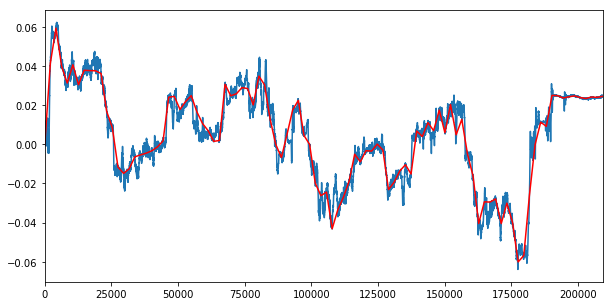

In [493]:
plt.figure(figsize=(10,5))
plt.plot(t, y, '-')
plt.plot(ipl_t, y_i, 'r')
plt.xlim([0.0, max(t)])

In [366]:
window = 500
n = len(pitch2)//window

In [422]:
xx = np.arange(500)
yy = pitch2[:500]

In [423]:
X=np.c_[np.ones(500),xx,xx**2,xx**3]

In [387]:
np.linalg.pinv(X)

array([[ 1.78567646e-02,  1.77140063e-02,  1.75717251e-02, ...,
         5.71543765e-03,  5.80981463e-03,  5.90466875e-03],
       [-1.42996875e-04, -1.41469474e-04, -1.39947822e-04, ...,
        -9.24276322e-05, -9.37572834e-05, -9.50926832e-05],
       [ 2.38566691e-07,  2.35698154e-07,  2.32841137e-07, ...,
         2.32841137e-07,  2.35698154e-07,  2.38566691e-07]])

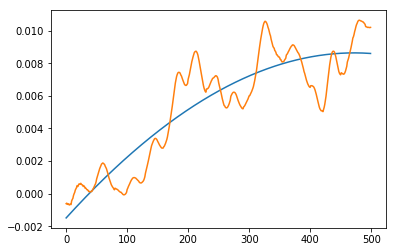

In [424]:
plt.plot(X.dot(np.linalg.pinv(X)).dot(yy))
plt.plot(pitch2[:500])

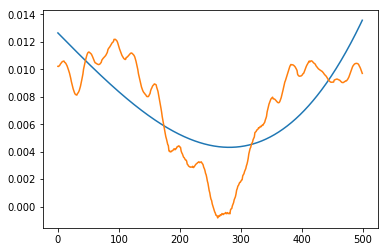

In [426]:
yy = pitch2[500:1000]
plt.plot(X.dot(np.linalg.pinv(X)).dot(yy))
plt.plot(list(range(500)), pitch2[500:1000])

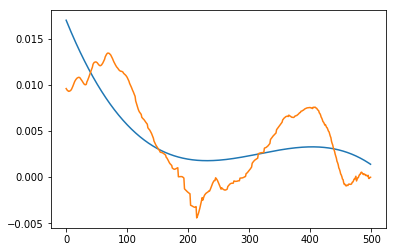

In [427]:
yy = pitch2[1000:1500]
plt.plot(X.dot(np.linalg.pinv(X)).dot(yy))
plt.plot(list(range(500)), pitch2[1000:1500])

In [433]:
ind = list(range(1500, 2000))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.033034534056100205

In [434]:
ind = list(range(1000, 1500))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.07140344678011301

In [435]:
ind = list(range(500, 1000))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.05645076284829464

In [436]:
ind = list(range(0, 500))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.03370796941283776

In [437]:
ind = list(range(2000, 2500))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.007334733704252164

In [438]:
ind = list(range(2500, 3000))
yy = pitch2[ind]
np.linalg.norm(X.dot(np.linalg.pinv(X)).dot(yy)-pitch2[ind])

0.020623721329539057

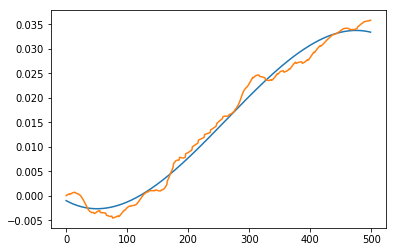

In [428]:
yy = pitch2[1500:2000]
plt.plot(X.dot(np.linalg.pinv(X)).dot(yy))
plt.plot(list(range(500)), pitch2[1500:2000])

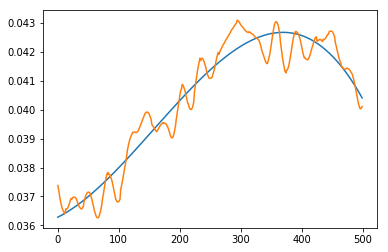

In [441]:
yy = pitch2[15000:15500]
plt.plot(X.dot(np.linalg.pinv(X)).dot(yy))
plt.plot(list(range(500)), pitch2[15000:15500])

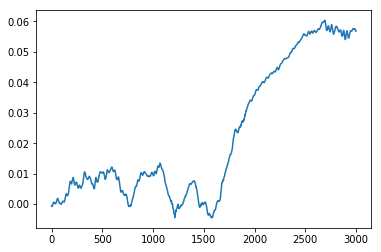

In [365]:
plt.plot(pitch2[:3000])

In [372]:
nn = pitch2-MA(pitch2, 5001)

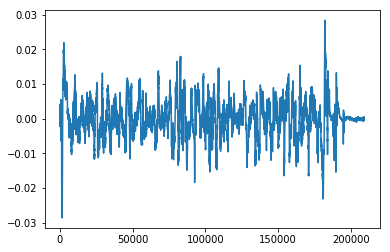

In [353]:
plt.plot(pitch2-MA(pitch2, 5001))

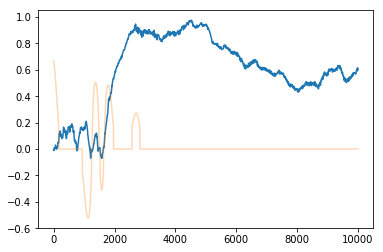

In [341]:
plt.plot(pitch2_tmp[:10000])
plt.plot((bias*200)[:10000], alpha=0.3)